In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import find_peaks
from codes import *
np.random.seed(12)


The variable $\Delta$ refers to the spacing between the antennas.

The variable $M$ refers to the number of antennas.

The variable $d$ refers to the direction of arrival of the signal.

The time of arrival of the signal at each antenna is defined by:

$\tau_M(\theta_i) = (M-1)\frac{\Delta \sin{\theta_i}}{c}$

The spatial frequencies are:

$\mu_i = - \frac{2\pi f_c}{c}\Delta \sin(\theta_i) \therefore \mu_i = -\pi \sin(\theta_i)$ if $\Delta = \frac{\lambda}{2}$.


In [2]:
# Definindo os parametros a serem utilizados

c_velocity = 3e8
frequency = 2.4e9 # 2.4 GHz
wavelength = c_velocity / frequency
delta = wavelength / 2 # Espaço entre cada antena

m_antennas = 8 # Número de antenas
d_arrival = 2 # Distância de chegada
theta_i = [-30, 60] # Ângulos de chegada
t_snapshot = 100 # Número de snapshots
snr = 0 # dB

$\mathbf{A_{ula}} \in \mathbb{C}^{M \times d}$ 

$\mathbf{S} \in \mathbb{C}^{d \times t}$ 

$\mathbf{N} \in \mathbb{C}^{M \times t}$ 

$\mathbf{X} = \mathbf{A_{ula}}\mathbf{S}+\mathbf{N},\;$ $\mathbf{X} \in \mathbb{C}^{M \times t}$ 

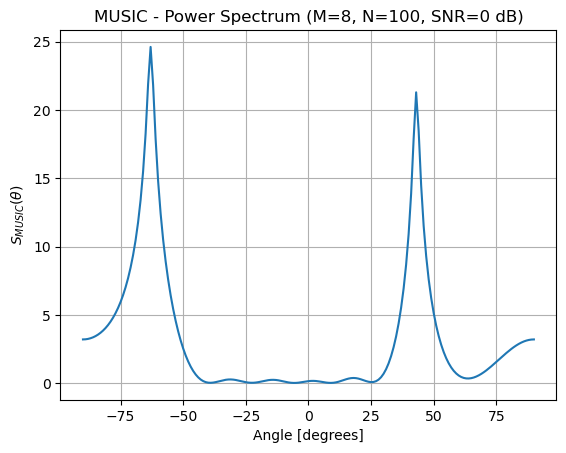

Picos encontrados: [-63  43]
Ângulos verdadeiros: [-62.25068837  43.20894537]
Erro médio: 0.5500573084553414 graus


In [3]:


theta_i = generate_angles_with_min_diff(d_arrival, 20)

A_ula = gerate_a_ula(m_antennas, d_arrival, theta_i)

angles, p_spectrum = generate_music(A_ula, d_arrival, t_snapshot, m_antennas, snr)


# Plotando o espectro de potência
plt.plot(angles, lin2db(p_spectrum))
plt.xlabel('Angle [degrees]')
plt.ylabel('$S_{MUSIC}(\\theta)$')
plt.title(f'MUSIC - Power Spectrum (M={m_antennas}, N={t_snapshot}, SNR={snr} dB)')
plt.grid()
plt.show()

picos, _ = find_peaks_d(p_spectrum, d_arrival)
print(f'Picos encontrados: {picos}')
print(f'Ângulos verdadeiros: {theta_i}')
print(f'Erro médio: {np.sqrt(np.mean(np.abs(picos - theta_i)**2))} graus')  


So far, we have worked with SNR = $0$, but now we will plot for SNR = $ \{-5, 0, 5, 10, 15, 20\}$.

The change in SNR is related to the standard deviation of the noise, as the transmission power remains constant. Thus, to change the SNR, we have:

$P_{\text{noise}} = \frac{P_{t}}{\text{SNR}},$

Considering that we will transform the SNR from dB to linear and knowing that we model the noise as $P_{\text{noise}} \sim \mathcal{N}(0, \sigma^2)$, we have:

$\sigma = \sqrt{\frac{P_t}{\text{SNR}}},\; P_t = 1 \therefore \sigma = \sqrt{\text{SNR}^{-1}} = \frac{1}{\sqrt{\text{SNR}}}.$

Now, making the adjustment for the different SNR values.


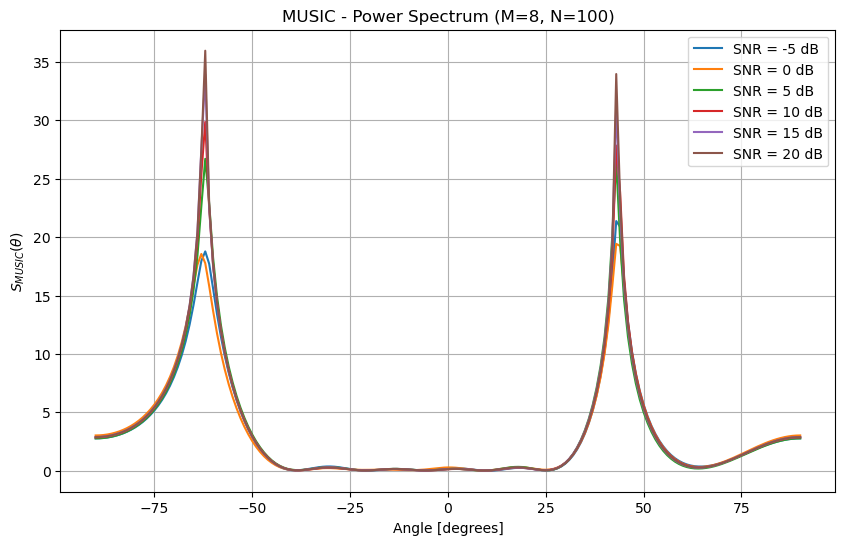

In [4]:
snr_values = np.arange(-5, 21, 5) # Valores de SNR em dB

plt.figure(figsize=(10,6))
for snr in snr_values:
    angles, p_spectrum = generate_music(A_ula, d_arrival, t_snapshot, m_antennas, snr)
    plt.plot(angles, lin2db(p_spectrum), label=f'SNR = {snr} dB')

plt.xlabel('Angle [degrees]')
plt.ylabel('$S_{MUSIC}(\\theta)$')
plt.title(f'MUSIC - Power Spectrum (M={m_antennas}, N={t_snapshot})')
plt.grid()
plt.legend()
plt.savefig('music_snrvariation.pdf')
plt.show()

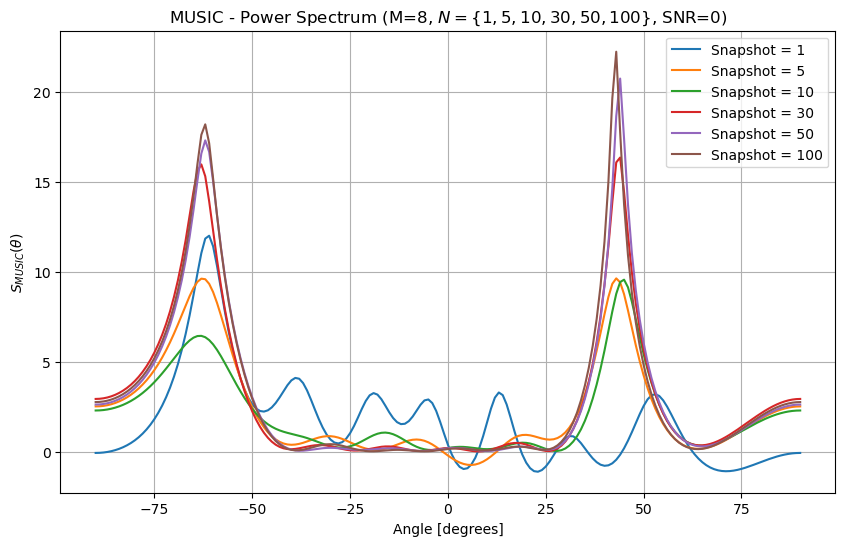

In [5]:
# Mudando agora a quantidade de snapshots:
t_snapshot_vector = [1,5,10,30,50,100]
plt.figure(figsize=(10,6))
for snapshot in t_snapshot_vector:
    angles, p_spectrum = generate_music(A_ula, d_arrival, snapshot, m_antennas, snr=0)
    plt.plot(angles, lin2db(p_spectrum), label=f'Snapshot = {snapshot}')

plt.xlabel('Angle [degrees]')
plt.ylabel('$S_{MUSIC}(\\theta)$')
plt.title('MUSIC - Power Spectrum (M=8, $N = \{1,5,10,30,50,100\}$, SNR=0)')
plt.grid()
plt.legend()
plt.savefig('music_snapshotvariation.pdf')
plt.show()

Making a Monte Carlo Simulation, where the angle will follow a uniform distribution in $[-60, 60]$ for each SNR.

After that, we will make a RMSE($\hat{\phi_r}$), thats be definided by:

$RMSE(\hat{\phi_r})=\sqrt{\mathbb{E}[|\phi_r - \hat{\phi_r}|^2]}$

In [6]:
def find_rmse(snr_values: np.ndarray, iterations:int, m_antennas:int, d_arrival:int, t_snapshot:int):
    '''
    Calcula o RMSE (Root Mean Square Error) dos ângulos estimados pelo algoritmo MUSIC em diferentes valores de SNR.

    Parâmetros:
    - snr_values (list or np.ndarray): Lista de valores de SNR (em dB) a serem avaliados.
    - iterations (int): Número de iterações por valor de SNR.
    - m_antennas (int): Número de antenas no arranjo.
    - d_arrival (int): Número de ângulos de chegada (direções de chegada).
    - t_snapshot (int): Número de snapshots para estimativa de autocorrelação.

    Retorno:
    - rmse_maior (list): Lista com os valores de RMSE para os maiores ângulos estimados, correspondentes a cada SNR.
    - rmse_menor (list): Lista com os valores de RMSE para os menores ângulos estimados, correspondentes a cada SNR.

    '''

    rmse_maior = []
    rmse_menor = []
    for snr_index in snr_values:
        phi_maior = []
        phi_menor = []
        #phi_uniform = generate_angles_with_min_diff(d_arrival, min_diff=30)
        

        for iteration_index in range(iterations):

           # Gerando os ângulos de chegada
           # phi_uniform = [30, 60]
            phit_uniform = generate_angles_with_min_diff(d_arrival, 20)
            #phi_uniform = [0,60]

            
            A_ula = gerate_a_ula(m_antennas, d_arrival, phit_uniform)
            angles, p_spectrum = generate_music(A_ula, d_arrival, t_snapshot, m_antennas, snr_index)

            # Calculando os ângulos de pico estimados pelo MUSIC
            
            top_peak_angles, _ = find_peaks_d(p_spectrum, d_arrival)

            maior_diferenca = phit_uniform[0] - top_peak_angles[0] 
            menor_diferena = phit_uniform[1] - top_peak_angles[1]


            phi_maior.append(maior_diferenca)
            phi_menor.append(menor_diferena)

        


        phi_maior = np.array(phi_maior)
        phi_menor = np.array(phi_menor)



        # Calculando o RMSE

        rmse_maior.append(np.sqrt(np.mean(np.abs(phi_maior)**2)))
        rmse_menor.append(np.sqrt(np.mean(np.abs(phi_menor)**2)))

    return rmse_maior, rmse_menor


In [ ]:
snr_values = np.arange(-5, 21, 5) # Valores de SNR em dB
iterations = 500 # Número de iterações
t_snapshot = 500 # Número de snapshots
rmse_maior, rmse_menor = find_rmse(snr_values, iterations, m_antennas, d_arrival, t_snapshot)

In [ ]:
a = np.array(rmse_maior)
print(a)

[22.90129247 22.92872407 21.84438114 17.48721875  9.7027832  11.4221379 ]


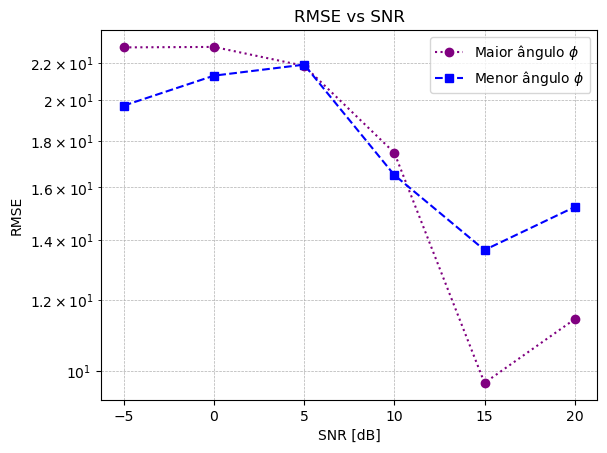

In [ ]:
plt.figure()
plt.plot(snr_values, rmse_maior,marker='o', label='Maior ângulo $\phi$', linestyle = ':', color = 'purple')
plt.plot(snr_values, rmse_menor,marker='s', label='Menor ângulo $\phi$', linestyle = '--', color = 'blue')

plt.yscale("log")

plt.xlabel('SNR [dB]')
plt.ylabel('RMSE')
plt.title('RMSE vs SNR')
plt.legend()
plt.xticks(snr_values)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.savefig('rmse_music.pdf')
plt.show()